In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
CURRENT_DIR = os.getcwd()  

In [3]:
os.chdir("./Datalogs")

In [4]:
# Import datalog files txt

extension = 'txt'
todos_los_archivos = [i for i in glob.glob('*.{}'.format(extension))]

In [5]:
# Combine all the files in the directory and generate dataframe
# Export the result to a CSV file

df = pd.concat([pd.read_csv(f) for f in todos_los_archivos ])


os.chdir(CURRENT_DIR)
df.to_csv( "combinado_csv.csv", index=False, encoding='utf-8-sig')

In [7]:
# The 'Datetime' column is converted to the 'datetime' column and format 
# to be able to use the functions of the Pandas library

df['datetime'] = pd.to_datetime(df['date_time'],format = '%d/%m/%Y %H:%M:%S')

In [8]:
# The 'datetime' column is set as the index.
# The dataset is ordered chronologically

df = df.set_index('datetime')
df.sort_index(inplace=True)

In [9]:
df

,date_time,tempC,HR,pressure,HRsoil,Vsensor
datetime,,,,,,
2024-05-04 11:52:00,04/05/2024 11:52:00,19.31,66.11,1014.20,84,1.007
2024-05-04 12:02:00,04/05/2024 12:02:00,18.95,69.14,1014.10,83,1.015
2024-05-04 12:12:00,04/05/2024 12:12:00,18.98,68.49,1014.09,82,1.020
2024-05-04 12:22:00,04/05/2024 12:22:00,19.04,66.17,1014.07,81,1.026
2024-05-04 12:32:00,04/05/2024 12:32:00,19.15,65.83,1014.04,81,1.029
...,...,...,...,...,...,...
2024-06-18 10:02:00,18/06/2024 10:02:00,17.76,79.62,1007.97,95,0.904
2024-06-18 10:12:00,18/06/2024 10:12:00,17.86,79.73,1008.00,95,0.909
2024-06-18 10:22:00,18/06/2024 10:22:00,18.15,79.25,1008.04,95,0.912


In [10]:
# RH of the substrate is calculated with floating precision using the sensor regression constants

m = -116.0468780696
b = 200.375395304049
df['HRsoilCalc'] = (df['Vsensor']* m) + b
df = df[['date_time','tempC','HR','pressure','HRsoil','HRsoilCalc','Vsensor']]

In [12]:
# The original column 'Date Time', 'Vsensor' and 'Hsil' are deleted

df = df.drop(columns=['date_time', 'HRsoil', 'Vsensor'])
#df.columns

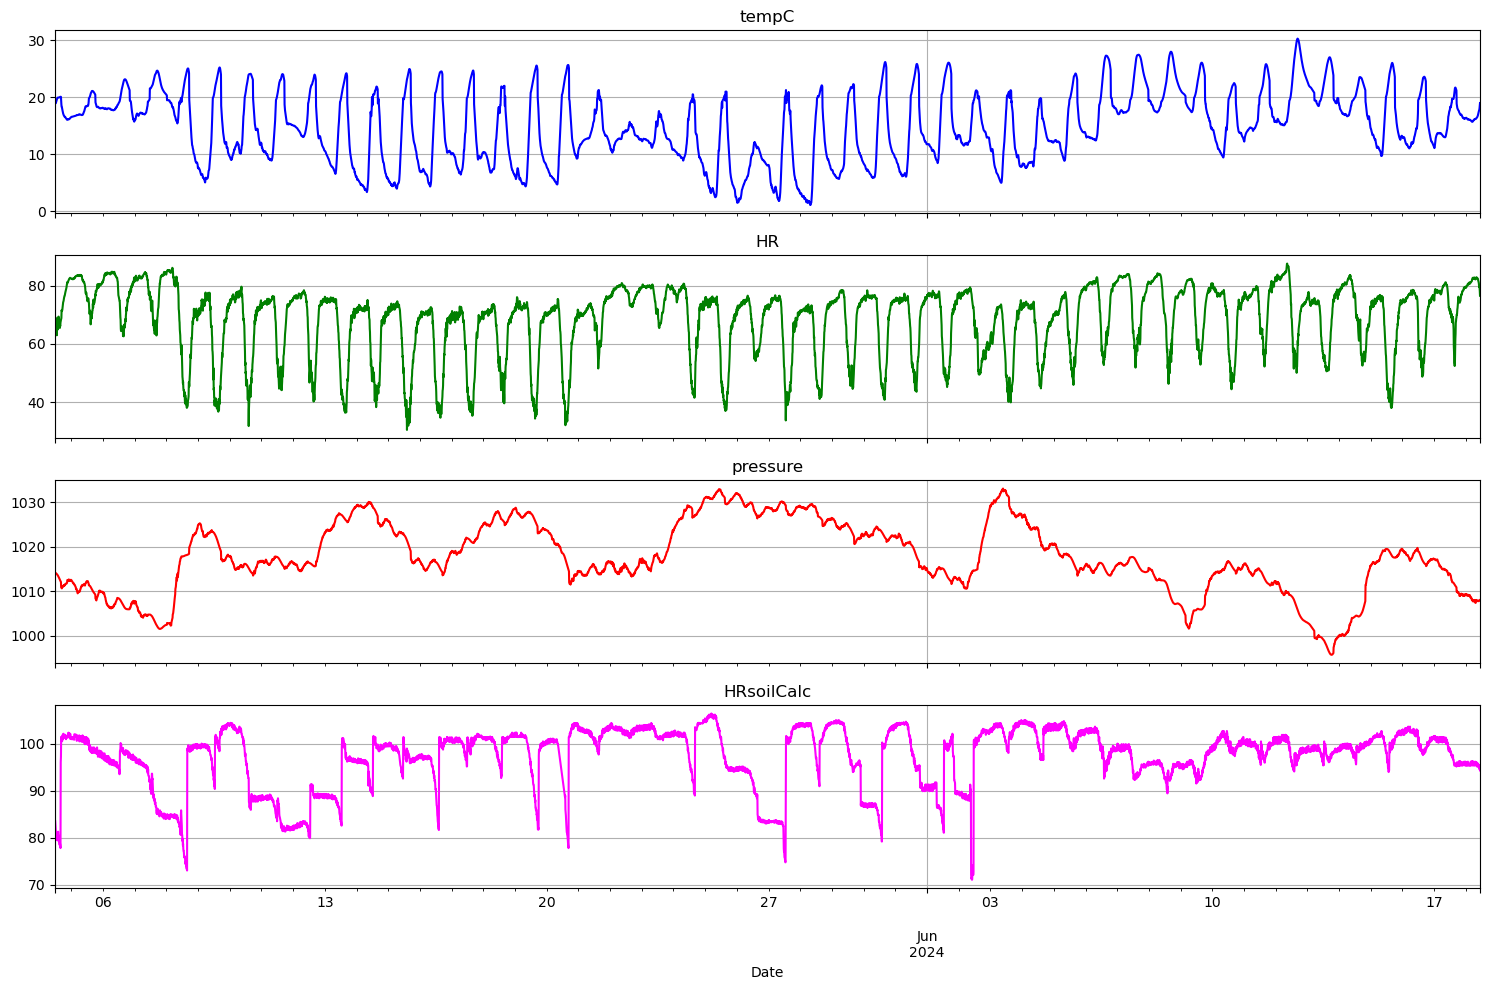

In [14]:
# Define colors for each feature for visibility
# Plot each feature with specified color and share the x-axis
# Only show the x-axis label on the last subplot

colors = ['blue', 'green', 'red',  'magenta']
n_features = 4
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    df[feature].plot(ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

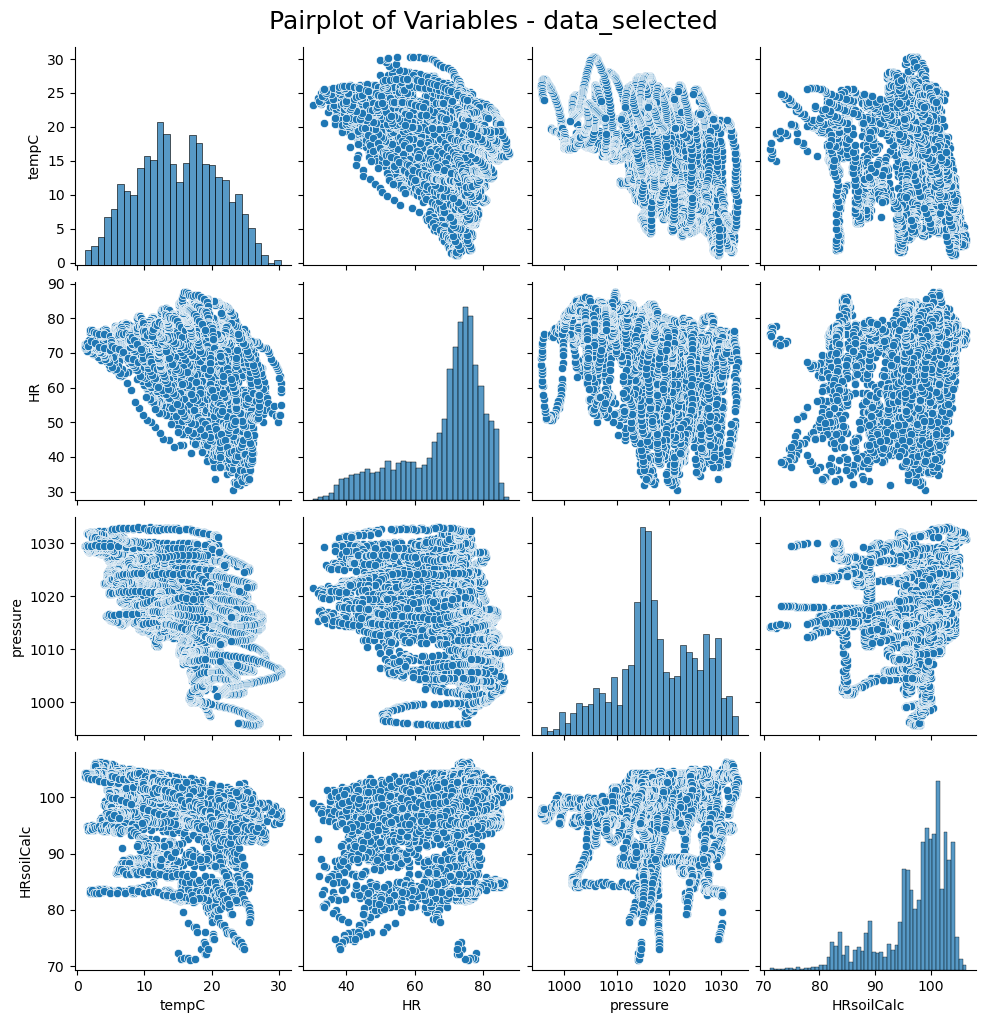

In [15]:
# It is analyzed if there is a linear relationship between co-variables.

sns.pairplot(df)
plt.suptitle('Pairplot of Variables - data_selected', fontsize=18, y=1.02);

In [17]:
# Missing data analysis: Missing data will simply be those cells within the data set that do not contain numerical quantities.
# Usually these cells will contain values like NaN (or Not A Number)

print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna tempC: 0
	Columna HR: 0
	Columna pressure: 0
	Columna HRsoilCalc: 0


In [19]:
# Analysis of the periodicity of the dataset
# We must verify if there is a temporal difference of exactly 10 minutes (600 seconds) between consecutive samples of the data set, which is the difference that could be seen between samples, when viewing part of it.
# This verification is key to ensuring that the LSTM models we will implement later will learn to properly detect patterns in the time series.

df_time_diffs = df.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

datetime
600.0    6473
Name: count, dtype: int64


In [20]:
# Sample if there are periods between samples different from the desired one

print(df_time_diffs[df_time_diffs != 600.0])

datetime
2024-05-04 11:52:00   NaN
Name: datetime, dtype: float64


In [22]:
# Función para generar las particiones preservando las características de la serie de tiempo



In [23]:
# Function to generate the dataset partitions preserving the characteristics of the time series

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Nval = int(N*vl_size)     # Número de datos de validación
    Ntst = int(N*ts_size)     # Número de datos de prueba
    Ntrain = N - Ntst - Nval  # Número de datos de entrenamiento
    
    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

In [25]:
# Execute the dataset separation function

data_tr, data_vl, data_ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {data_tr.shape}')
print(f'Tamaño set de validación: {data_vl.shape}')
print(f'Tamaño set de prueba: {data_ts.shape}')

Tamaño set de entrenamiento: (5180, 4)
Tamaño set de validación: (647, 4)
Tamaño set de prueba: (647, 4)


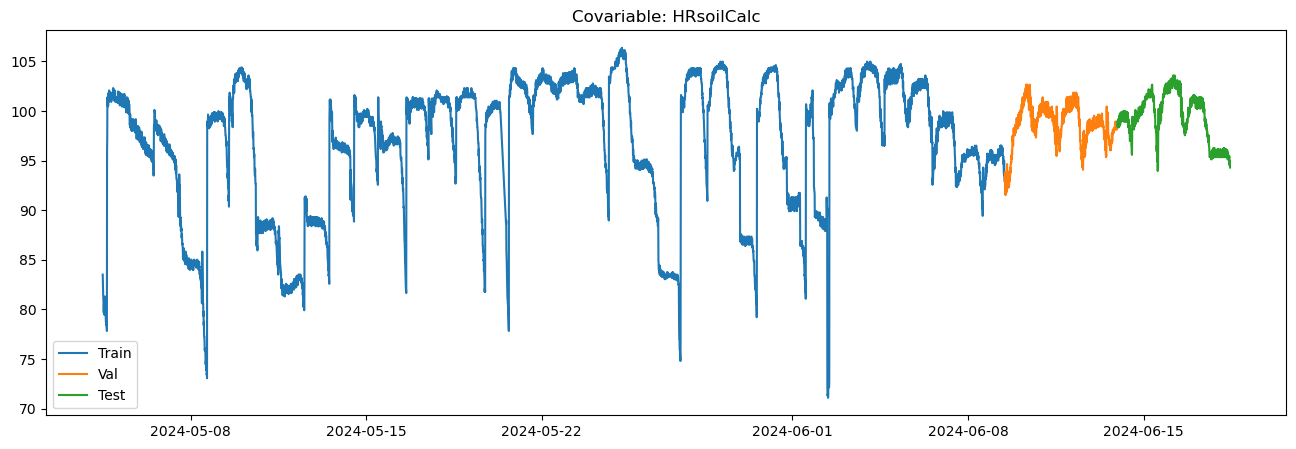

In [27]:
# WE VERIFY IN SOME COLUMN AS A REFERENCE, that the data of each of the sets is not mixed and is consecutive

covar = 3                           # Index of the covariate to be graphed
col = df.columns[covar]


# Draw the training/validation/test sets for the covariate
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(data_tr[col], label='Train')
ax.plot(data_vl[col], label='Val')
ax.plot(data_ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [28]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
data_tr_n = scaler.fit_transform(data_tr)
data_vl_n = scaler.transform(data_vl)
data_ts_n = scaler.transform(data_ts)

In [29]:
# Save the scaler parameters to a Text file

os.chdir("./")

with open('scaler_params.txt', 'w') as file:
    file.write('scale:' + ','.join(map(str, scaler.scale_)) + '\n')
    file.write('min:' + ','.join(map(str, scaler.min_)) + '\n')
    file.write('data_min:' + ','.join(map(str, scaler.data_min_)) + '\n')
    file.write('data_max:' + ','.join(map(str, scaler.data_max_)) + '\n')
    file.write('data_range:' + ','.join(map(str, scaler.data_range_)) + '\n')


In [30]:
print(f'Train: {data_tr_n.min()}, {data_tr_n.max()}')
print(f'Test:  {data_ts_n.min()}, {data_ts_n.max()}')
print(f'Val:   {data_vl_n.min()}, {data_vl_n.max()}')

Train: 0.0, 1.0
Test:  -0.06077872744539192, 0.9547738693467334
Val:   -0.18486862931306902, 1.0854700854700856


### Generación del dataset supervisado (entrada y salida del modelo)

**Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la documentación de las Redes LSTM en TensorFlow/Keras:** https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [31]:
# Generation of the supervised dataset (model input and output)
# We must adjust our data set according to what is specified in the LSTM Networks documentation in TensorFlow/Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM


def crear_dataset_supervisado(array, input_length, future_step, out_feat_index):
    # Inicialización
    X, Y = [], []    # Lists that will contain the input and output data of the model
    fils, cols = array.shape

    # Generate the lists
    len(array)-input_length-future_step):
        
        # Model´s Inputs
        X.append(array[i:i+input_length,0:cols])

        # Model´s Output
        Y.append(array[i+input_length+future_step-1, out_feat_index])

    # Convert lists to NumPy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [32]:
# Create the training, test and validation datasets and verify their sizes

INPUT_LENGTH = 144      # 6 muestreos por hora x 24 horas = 144
FUTURE_STEP = 3         # Target output to N steps
OUTPUT_FEA_INDEX = 3    # Index of the variable to be predicted

x_tr_n, y_tr_n = crear_dataset_supervisado(data_tr_n, INPUT_LENGTH, FUTURE_STEP, OUTPUT_FEA_INDEX)
x_vl_n, y_vl_n = crear_dataset_supervisado(data_vl_n, INPUT_LENGTH, FUTURE_STEP, OUTPUT_FEA_INDEX)
x_ts_n, y_ts_n = crear_dataset_supervisado(data_ts_n, INPUT_LENGTH, FUTURE_STEP, OUTPUT_FEA_INDEX)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr_n: {x_tr_n.shape}, y_tr_n: {y_tr_n.shape}')
print(f'Set de validación - x_vl_n: {x_vl_n.shape}, y_vl_n: {y_vl_n.shape}')
print(f'Set de prueba - x_ts_n: {x_ts_n.shape}, y_ts_n: {y_ts_n.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr_n: (5141, 36, 4), y_tr_n: (5141,)
Set de validación - x_vl_n: (608, 36, 4), y_vl_n: (608,)
Set de prueba - x_ts_n: (608, 36, 4), y_ts_n: (608,)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam

In [34]:
# Model creation

N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_n.shape[1], x_tr_n.shape[2]) # 144 (muestras, equivale a 24 horas) x 4 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(1))


# Compile the model

modelo.compile(
    optimizer = 'adam',
    loss = 'mse',
)

In [35]:
# Define your batch size and EPOCHS

EPOCHS = 30       # Hiperparámetro
BATCH_SIZE = 20   # Hiperparámetro

In [36]:
# Define early stopping

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    mode='min',
    restore_best_weights=True)

In [37]:
# Model´s training

historia = modelo.fit(
    x = x_tr_n,
    y = y_tr_n,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_n, y_vl_n),
    callbacks=[early_stopping]
    #verbose=2
)

Epoch 1/30
258/258 [==============================] - 5s 7ms/step - loss: 0.0144 - val_loss: 0.0024
Epoch 2/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 9.2534e-04
Epoch 3/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 6.0509e-04
Epoch 4/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0037 - val_loss: 9.9992e-04
Epoch 5/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0034 - val_loss: 5.9418e-04
Epoch 6/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 8.0433e-04
Epoch 7/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 8/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 6.0679e-04
Epoch 9/30
258/258 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 6.2612e-04
Epoch 10/30
258/258 [==============================] - 1s 5ms/step - los

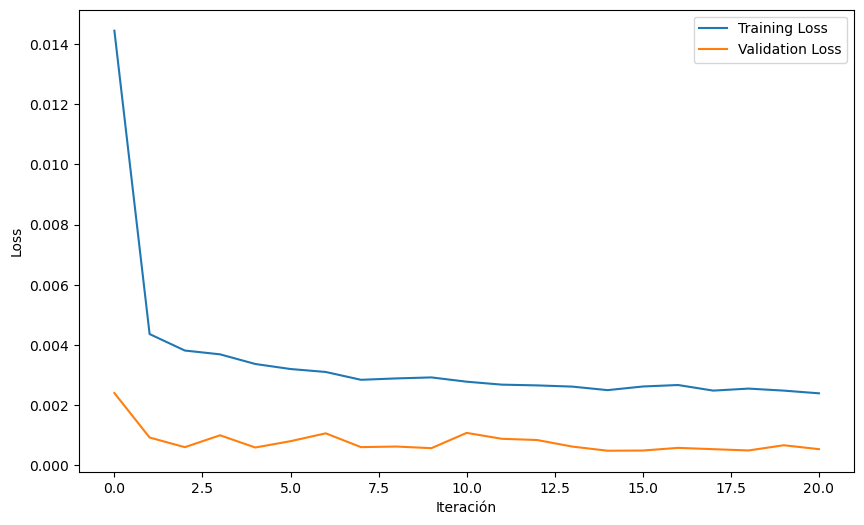

In [38]:
# Plot training and validation curves
# to verify that there is no overfitting
    
plt.figure(figsize=(10, 6))
plt.plot(historia.history['loss'],label='Training Loss')
plt.plot(historia.history['val_loss'],label='Validation Loss')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.legend();
plt.show()

In [39]:
# RMSE calculation for train, val and test

rmse_tr = modelo.evaluate(x=x_tr_n, y=y_tr_n, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_n, y=y_vl_n, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_n, y=y_ts_n, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.5f}')
print(f'  RMSE val:\t {rmse_vl:.5f}')
print(f'  RMSE test:\t {rmse_ts:.5f}')

Comparativo desempeños:
  RMSE train:	 0.00259
  RMSE val:	 0.00049
  RMSE test:	 0.00036


In [ ]:
# Save the Model

TF_MODEL_NAME = "./modeloTF/tf_fl_keras_modelTest_LSTM.h5"
modelo.save(TF_MODEL_NAME)


## Predicciones con el modelo entrenado

Suponiendo que el modelo ya ha sido afinado, podemos ponerlo a prueba con el set test.

Usaremos la función 'predecir':

In [ ]:
# Predictions with the trained model
# Assuming that the model has already been tuned, we can put it to the test with the set test. 
# We will use the 'predict' function:

predictions = modelo.predict(x_ts_n)

In [ ]:
# Load the scaler parameters from the text file
loaded_scaler_params = {}
with open('scaler_params.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        loaded_scaler_params[key] = np.array([float(i) for i in value.split(',')])

# Create a new scaler instance and set its parameters
inference_scaler = MinMaxScaler()
inference_scaler.scale_ = loaded_scaler_params['scale']
inference_scaler.min_ = loaded_scaler_params['min']
inference_scaler.data_min_ = loaded_scaler_params['data_min']
inference_scaler.data_max_ = loaded_scaler_params['data_max']
inference_scaler.data_range_ = loaded_scaler_params['data_range']

In [ ]:
inference_scaler.data_min_.shape

In [ ]:
data_min = inference_scaler.data_min_[3]

In [ ]:
data_max = inference_scaler.data_max_[3]

In [ ]:
predictions_inverse = predictions * (data_max - data_min) + data_min
y_test_inverse = y_ts_n * (data_max - data_min) + data_min

In [ ]:
N = 200  # Number of points to plot

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[:N], label= 'Actual HR Soil', color='blue', marker='.', linestyle='-', linewidth=1, markersize=5)
plt.plot(predictions_inverse[:N], label='Predicted HR Soil', color='red', marker='.', linestyle='-', linewidth=1, markersize=5)
plt.title(f'Actual vs Predicted HR')
plt.xlabel('Time Step')
plt.ylabel('%')
plt.legend()
plt.show()

## Create TFLite LSTM Model - Float32
- EI does support LSTM since tflite micro update last year, but it comes with a few limitations, most importantly, the converted tflite model should have **UnidirectionalLSTM** operator
- Float32 is supported and tested, while quantized model does not seem to work (even with full tflite)

### Conversion to a TensorFlow Lite model with the UnidirectionalLSTM operator

In [ ]:
TF_LITE_MODEL_NAME = "tf_lite_model_UnidireccionalLSTM.tflite"

run_model = tf.function(lambda x: modelo(x))

# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 144
INPUT_SIZE = 4
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], modelo.inputs[0].dtype))

# model directory.
MODEL_DIR = "modelo_keras_lstm"
modelo.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Save the converted model to file
with open(TF_LITE_MODEL_NAME, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Initialize the TFLite interpreter
interp = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
interp.allocate_tensors()

# Get input/output layer information
i_details = interp.get_input_details()[0]
o_details = interp.get_output_details()[0]

In [ ]:
i_details

In [ ]:
o_details

In [ ]:
import edgeimpulse as ei
ei.API_KEY = "ei_XXxxxxxxxxXXxxxxxxxxxxxxxxxxxx<x<<x<x<x<x>xxx" # PUT YOUR Edgeimpulse key HERE 

In [ ]:
# Estimate the RAM, ROM, and inference time for our model on the target hardware family
try:
    profile = ei.model.profile(model=tflite_model,
                               device='espressif-esp32')
    print(profile.summary())
except Exception as e:
    print(f"Could not profile: {e}")

In [ ]:
# Create Arduino library with trained model
download_dir = "./"
deploy_filename = "lstm_float32_model_3step.zip"
deploy_bytes = None

try:
    deploy_bytes = ei.model.deploy(tflite_model,
                                   model_output_type=ei.model.output_type.Regression(),
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")

# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

## Generate test datapoint for inference


In [ ]:
x_ts_n[200].shape

In [ ]:
reshaped_test = x_ts_n[200].reshape(-1)
reshaped_test.shape

In [ ]:
reshaped_test

In [ ]:
## NORMALIZED REAL VALUE FOR INPUT DATA SET [200]

y_ts_n[200]

In [ ]:
## REAL VALUE FOR INPUT DATA SET [200]

data_ts[345:346]

In [ ]:
## VALUE PREDICTED BY THE TENSORFLOW MODEL FOR THE INPUT DATA SET [200]

check = modelo.predict(x_ts_n,verbose=0)
check[200]

In [ ]:
## VALUE PREDICTED BY THE TFLitle MODEL FOR THE INPUT DATA SET [200]

x_ts_x = np.expand_dims(x_ts_n[200], axis=0)

interp.set_tensor(i_details['index'], np.float32(x_ts_x))
interp.invoke()

output_data = interp.get_tensor(o_details['index'])
print(output_data)